In [1]:
import tensorflow as tf
#tensorflow_hub import 수행.
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [ ]:
print(tf.__version__)

In [2]:
!nvidia-smi

Thu Jun 15 14:03:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 입력 이미지로 사용될 이미지 다운로드

In [3]:
!mkdir /content/data
!wget -O ./data/beatles01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg

--2023-06-15 14:04:13--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/beatles01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383118 (374K) [image/jpeg]
Saving to: ‘./data/beatles01.jpg’

./data/beatles01.jp 100%[===================>] 374.14K  --.-KB/s    in 0.03s   

2023-06-15 14:04:13 (10.6 MB/s) - ‘./data/beatles01.jpg’ saved [383118/383118]



### TF Hub에서 SSD Inference 모델 다운로드 후 Inference 수행.
* 원하는 모델명은 TF Hub에서 검색해서 hub.lod()로 다운로드 후 tensorflow로 사용 가능할 수 있도록 로딩됨
* 로딩된 모델은 바로 원본 이미지로 Object Detection이 가능. 입력 이미지 값으로 numpy array, tensor 모두 가능하며 uint8로 구성 필요.
* inference 결과는 dictionary 형태로 반환되며, 개별 key값은 Object Detection 모델에 따라 달라질 수 있음. 개별 value는 tensor로 되어 있음.
* inference 반환된 bbox 좌표는 이미지 사이즈 대비 스케일링 된 0~1 사이 값이며 **ymin, xmin, ymax, xmax 형태로 반환되므로 반드시 주의 필요**

In [3]:
# https://tfhub.dev/ 에서 ssd 로 해당 pretrained 모델의 URL 가져옴.
module_handle = "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"
detector_model = hub.load(module_handle)

In [4]:
import cv2
import numpy as np
import time

# 3차원 numpy array를 4차원으로 변경
img_array_np = cv2.imread('/content/data/beatles01.jpg')
img_array = img_array_np[np.newaxis, ...]
print(img_array_np.shape, img_array.shape)

start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행.
result = detector_model(img_array)
print('elapsed time:', time.time()-start_time)


(633, 806, 3) (1, 633, 806, 3)
elapsed time: 4.797809600830078


In [5]:
# 4차원 tensor로 이미지를 입력
img_tensor = tf.convert_to_tensor(img_array_np, dtype=tf.uint8)[tf.newaxis, ...]
start_time = time.time()
# image를 detector_model에 인자로 입력하여 inference 수행.
result = detector_model(img_tensor)
print('elapsed time:', time.time()-start_time)

elapsed time: 0.05179262161254883


In [6]:
# inference 결과 출력. dictionary 형태의 출력 결과. dict내부의 key는 model 별로 서로 다름. 출력하여 key값 확인 필요.
print(result)

{'detection_classes': <tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.,  3.,  1.,  3.,  3.,  1.,  3.,  3.,  3.,  3.,  3.,  3.,  1.,
         1.,  3.,  3.,  3.,  3.,  3.,  1.,  3.,  8.,  1.,  4.,  1.,  3.,
         3.,  3.,  1.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  2.,  1.,
         1., 41., 15., 15.,  9.,  1.,  3.,  3.,  1.,  1., 15.,  4.,  1.,
         1., 15.,  1., 28., 37.,  8.,  1.,  3.,  4., 10.,  3.,  8.,  1.,
         1.,  3.,  1.,  1., 31.,  9.,  3.,  1.,  1.,  8.,  3.,  1.,  3.,
         1., 31., 15.,  1., 31.,  3.,  1.,  1.,  3.,  1.,  1., 37.,  4.,
        10., 31., 31.,  3.,  1.,  1.,  8.,  1., 34.]], dtype=float32)>, 'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
array([[[0.4149563 , 0.4789079 , 0.8861095 , 0.6805986 ],
        [0.35446182, 0.6193308 , 0.4560112 , 0.7103389 ],
        [0.42462415, 0.07202516, 0.8726056 , 0.2496268 ],
        [0.34840307, 0.57042307, 0.4265056 , 0.6450172 ],
        [0.35190699, 0.49550375, 0.372064

In [7]:
print(result.keys())
# detect 결과는 100개를 기본으로 Detect 함(즉 Detect된 오브젝트는 무조건 100개. 그래서 tensor(array)는 100개 단위)
print(result['detection_boxes'].shape, result['detection_classes'].shape, result['num_detections'].shape, result['detection_scores'].shape)

dict_keys(['detection_classes', 'detection_boxes', 'detection_scores', 'detection_anchor_indices', 'num_detections', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores'])
(1, 100, 4) (1, 100) (1,) (1, 100)


In [8]:
# detect된 object들은 detection score가 높은 순으로 array값을 순차적으로 채움.
print('#### detection_classes #####')
print(result['detection_classes'])
print('#### detection_scores #####')
print(result['detection_scores'])

#### detection_classes #####
tf.Tensor(
[[ 1.  3.  1.  3.  3.  1.  3.  3.  3.  3.  3.  3.  1.  1.  3.  3.  3.  3.
   3.  1.  3.  8.  1.  4.  1.  3.  3.  3.  1.  1.  1.  1.  3.  1.  1.  1.
   1.  2.  1.  1. 41. 15. 15.  9.  1.  3.  3.  1.  1. 15.  4.  1.  1. 15.
   1. 28. 37.  8.  1.  3.  4. 10.  3.  8.  1.  1.  3.  1.  1. 31.  9.  3.
   1.  1.  8.  3.  1.  3.  1. 31. 15.  1. 31.  3.  1.  1.  3.  1.  1. 37.
   4. 10. 31. 31.  3.  1.  1.  8.  1. 34.]], shape=(1, 100), dtype=float32)
#### detection_scores #####
tf.Tensor(
[[0.8017293  0.7356188  0.71201706 0.69413894 0.6636528  0.6556505
  0.6452406  0.60372716 0.6026705  0.5842153  0.56527364 0.5350405
  0.53426534 0.5268754  0.52053607 0.50956285 0.49782982 0.4945502
  0.49444333 0.48153725 0.4632208  0.44349    0.43932414 0.438504
  0.43563345 0.42940426 0.40469146 0.40248087 0.40042165 0.3880498
  0.37969708 0.37923118 0.35729325 0.35150275 0.3513088  0.34515947
  0.34445196 0.3431206  0.34093928 0.3407752  0.33898044 0.33623484
  0.3

In [9]:
# bounding box 좌표는 ymin, xmin, ymax, xmax 순서로 반환됨. y가 먼저, x가 나중에 나오므로 반드시 주의해야 함.
# 좌표 값은 원본 이미지의 width, height로 0~1 사이값으로 정규화됨.
print('#### detection_boxes #####')
print(result['detection_boxes'])

#### detection_boxes #####
tf.Tensor(
[[[0.4149563  0.4789079  0.8861095  0.6805986 ]
  [0.35446182 0.6193308  0.4560112  0.7103389 ]
  [0.42462415 0.07202516 0.8726056  0.2496268 ]
  [0.34840307 0.57042307 0.4265056  0.6450172 ]
  [0.35190699 0.49550375 0.37206444 0.51862085]
  [0.43273562 0.2820462  0.8654354  0.45395404]
  [0.34878334 0.5463882  0.37784776 0.5763231 ]
  [0.3735987  0.38559082 0.41415024 0.42749032]
  [0.3549313  0.45743853 0.3715493  0.4719668 ]
  [0.38732827 0.162126   0.5466345  0.31490028]
  [0.35574898 0.53846586 0.41043958 0.595577  ]
  [0.35995895 0.74961007 0.4518572  0.80073214]
  [0.41962266 0.37767807 0.49098235 0.41628668]
  [0.40850353 0.69716555 0.88816273 0.87542397]
  [0.37630147 0.8410377  0.4158867  0.88230294]
  [0.3869046  0.8088866  0.42234337 0.8531973 ]
  [0.35546145 0.66919553 0.45342818 0.7328212 ]
  [0.33963862 0.5889446  0.3827575  0.64008945]
  [0.41962266 0.37767807 0.49098235 0.41628668]
  [0.39901894 0.7998833  0.5149196  0.85316366]
  

### inference 결과를 이미지로 시각화

In [10]:
# result내의 value들을 모두 numpy로 변환.
# result은 디셔너리 형태로 되어있고 value값이 텐서로 되어있다 그래서 시각화하기 쉽게 하기 위해 이를 넘파이로 바꿔야한다
result = {key:value.numpy() for key,value in result.items()}

In [11]:
result

{'detection_classes': array([[ 1.,  3.,  1.,  3.,  3.,  1.,  3.,  3.,  3.,  3.,  3.,  3.,  1.,
          1.,  3.,  3.,  3.,  3.,  3.,  1.,  3.,  8.,  1.,  4.,  1.,  3.,
          3.,  3.,  1.,  1.,  1.,  1.,  3.,  1.,  1.,  1.,  1.,  2.,  1.,
          1., 41., 15., 15.,  9.,  1.,  3.,  3.,  1.,  1., 15.,  4.,  1.,
          1., 15.,  1., 28., 37.,  8.,  1.,  3.,  4., 10.,  3.,  8.,  1.,
          1.,  3.,  1.,  1., 31.,  9.,  3.,  1.,  1.,  8.,  3.,  1.,  3.,
          1., 31., 15.,  1., 31.,  3.,  1.,  1.,  3.,  1.,  1., 37.,  4.,
         10., 31., 31.,  3.,  1.,  1.,  8.,  1., 34.]], dtype=float32),
 'detection_boxes': array([[[0.4149563 , 0.4789079 , 0.8861095 , 0.6805986 ],
         [0.35446182, 0.6193308 , 0.4560112 , 0.7103389 ],
         [0.42462415, 0.07202516, 0.8726056 , 0.2496268 ],
         [0.34840307, 0.57042307, 0.4265056 , 0.6450172 ],
         [0.35190699, 0.49550375, 0.37206444, 0.51862085],
         [0.43273562, 0.2820462 , 0.8654354 , 0.45395404],
         [0.3487

In [12]:
# 1부터 91까지의 COCO Class id 매핑.
labels_to_names = {1:'person',2:'bicycle',3:'car',4:'motorcycle',5:'airplane',6:'bus',7:'train',8:'truck',9:'boat',10:'traffic light',
                    11:'fire hydrant',12:'street sign',13:'stop sign',14:'parking meter',15:'bench',16:'bird',17:'cat',18:'dog',19:'horse',20:'sheep',
                    21:'cow',22:'elephant',23:'bear',24:'zebra',25:'giraffe',26:'hat',27:'backpack',28:'umbrella',29:'shoe',30:'eye glasses',
                    31:'handbag',32:'tie',33:'suitcase',34:'frisbee',35:'skis',36:'snowboard',37:'sports ball',38:'kite',39:'baseball bat',40:'baseball glove',
                    41:'skateboard',42:'surfboard',43:'tennis racket',44:'bottle',45:'plate',46:'wine glass',47:'cup',48:'fork',49:'knife',50:'spoon',
                    51:'bowl',52:'banana',53:'apple',54:'sandwich',55:'orange',56:'broccoli',57:'carrot',58:'hot dog',59:'pizza',60:'donut',
                    61:'cake',62:'chair',63:'couch',64:'potted plant',65:'bed',66:'mirror',67:'dining table',68:'window',69:'desk',70:'toilet',
                    71:'door',72:'tv',73:'laptop',74:'mouse',75:'remote',76:'keyboard',77:'cell phone',78:'microwave',79:'oven',80:'toaster',
                    81:'sink',82:'refrigerator',83:'blender',84:'book',85:'clock',86:'vase',87:'scissors',88:'teddy bear',89:'hair drier',90:'toothbrush',
                    91:'hair brush'}

In [13]:
def get_ssd_detector(module_handle="https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2"):
  detector = hub.load(module_handle)
  return detector

detector_model = get_ssd_detector()

person: 0.7767
person: 0.7362
car: 0.7209
person: 0.7084
car: 0.6868
person: 0.6846
car: 0.6652
car: 0.6145
car: 0.5854
car: 0.5724
car: 0.5606
car: 0.5341
person: 0.5228


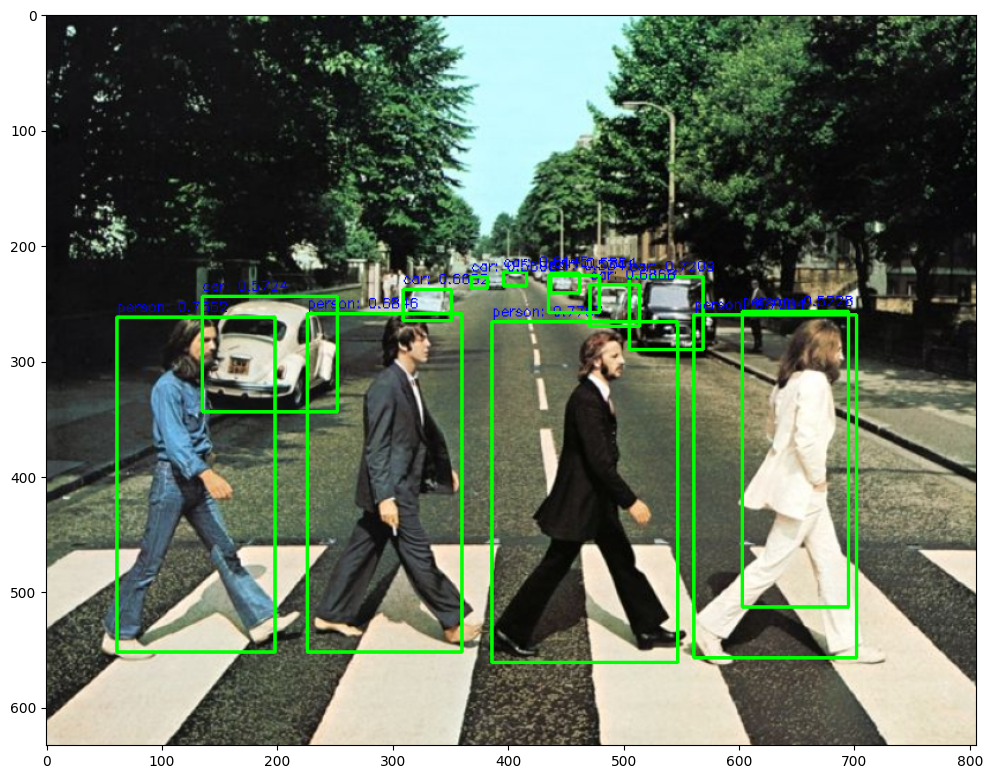

In [14]:
import cv2

img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)

# scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
height = img_array.shape[0]
width = img_array.shape[1]
# cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성.
draw_img = img_array.copy()

# bounding box의 테두리와 caption 글자색 지정
green_color=(0, 255, 0)
red_color=(0, 0, 255)

# cv2로 만들어진 numpy image array를 tensor로 변환
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
#img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

# ssd+mobilenet v2 모델을 다운로드 한 뒤 inference 수행.
result = detector_model(img_tensor)
# result 내부의 value를 numpy 로 변환.
result = {key:value.numpy() for key,value in result.items()}

SCORE_THRESHOLD = 0.5
OBJECT_DEFAULT_COUNT = 100

# detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
for i in range(min(result['detection_scores'][0].shape[0], OBJECT_DEFAULT_COUNT)):
  # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단.
  score = result['detection_scores'][0, i]
  if score < SCORE_THRESHOLD:
    break
  # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
  box = result['detection_boxes'][0, i]

  ''' **** 주의 ******
   box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
  left = box[1] * width
  top = box[0] * height
  right = box[3] * width
  bottom = box[2] * height

  # class id 추출하고 class 명으로 매핑
  class_id = result['detection_classes'][0, i]
  caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
  print(caption)
  #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
  cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
  cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [14]:
import time

def get_detected_img(model, img_array, score_threshold, object_show_count=100, is_print=True):
  # scaling된 이미지 기반으로 bounding box 위치가 예측 되므로 이를 다시 원복하기 위해 원본 이미지 shape정보 필요
  height = img_array.shape[0]
  width = img_array.shape[1]
  # cv2의 rectangle()은 인자로 들어온 이미지 배열에 직접 사각형을 업데이트 하므로 그림 표현을 위한 별도의 이미지 배열 생성.
  draw_img = img_array.copy()

  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)

  # cv2로 만들어진 numpy image array를 tensor로 변환
  img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
  #img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)[tf.newaxis, ...]

  # ssd+mobilenet v2 모델을 다운로드 한 뒤 inference 수행.
  start_time = time.time()
  result = model(img_tensor)
  # result 내부의 value를 numpy 로 변환.
  result = {key:value.numpy() for key,value in result.items()}

  # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
  for i in range(min(result['detection_scores'][0].shape[0], object_show_count)):
    # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단.
    score = result['detection_scores'][0, i]
    if score < score_threshold:
      break
    # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
    box = result['detection_boxes'][0, i]

    ''' **** 주의 ******
    box는 ymin, xmin, ymax, xmax 순서로 되어 있음. '''
    left = box[1] * width
    top = box[0] * height
    right = box[3] * width
    bottom = box[2] * height

    # class id 추출하고 class 명으로 매핑
    class_id = result['detection_classes'][0, i]
    caption = "{}: {:.4f}".format(labels_to_names[class_id], score)
    print(caption)
    #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
    cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)

  if is_print:
    print('Detection 수행시간:',round(time.time() - start_time, 2),"초")

  return draw_img

person: 0.7767
person: 0.7362
car: 0.7209
person: 0.7084
car: 0.6868
person: 0.6846
car: 0.6652
car: 0.6145
car: 0.5854
car: 0.5724
car: 0.5606
car: 0.5341
person: 0.5228
Detection 수행시간: 2.89 초


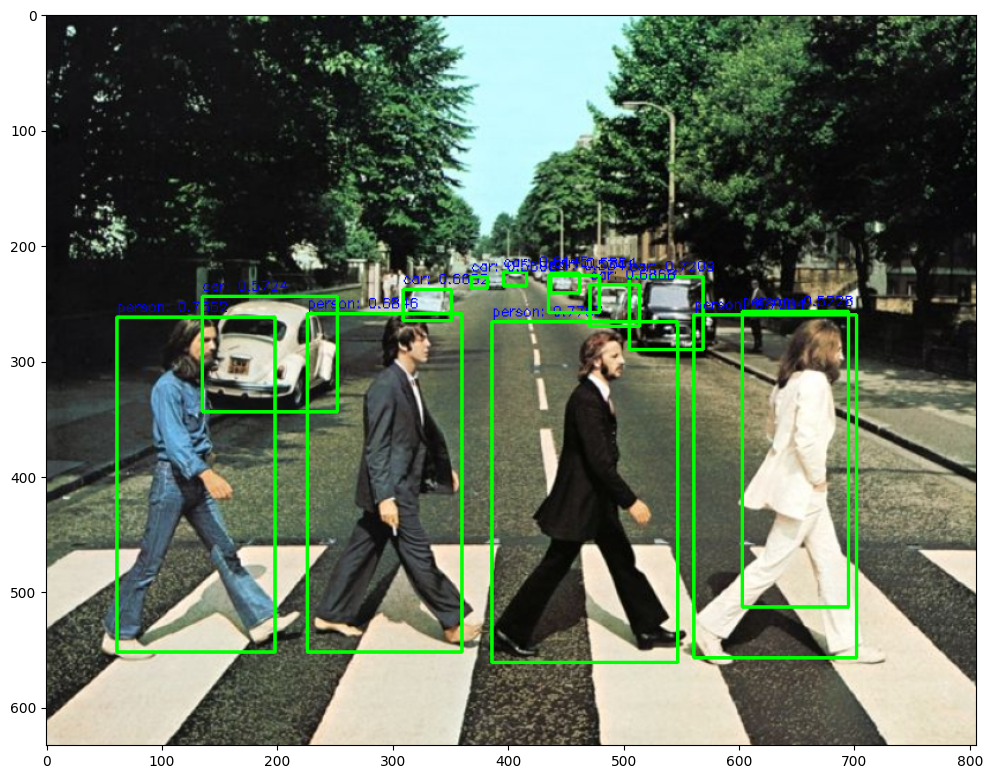

In [15]:
#detector_model = get_ssd_detector()

img_array = cv2.cvtColor(cv2.imread('/content/data/beatles01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.5, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

In [16]:
!wget -O ./data/baseball01.jpg https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg

--2023-06-15 14:29:23--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/image/baseball01.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76279 (74K) [image/jpeg]
Saving to: ‘./data/baseball01.jpg’

./data/baseball01.j 100%[===================>]  74.49K  --.-KB/s    in 0.01s   

2023-06-15 14:29:23 (5.92 MB/s) - ‘./data/baseball01.jpg’ saved [76279/76279]



person: 0.8886
person: 0.8754
person: 0.8638
baseball bat: 0.5842
baseball glove: 0.5645
baseball glove: 0.5182
baseball bat: 0.5007
Detection 수행시간: 0.06 초


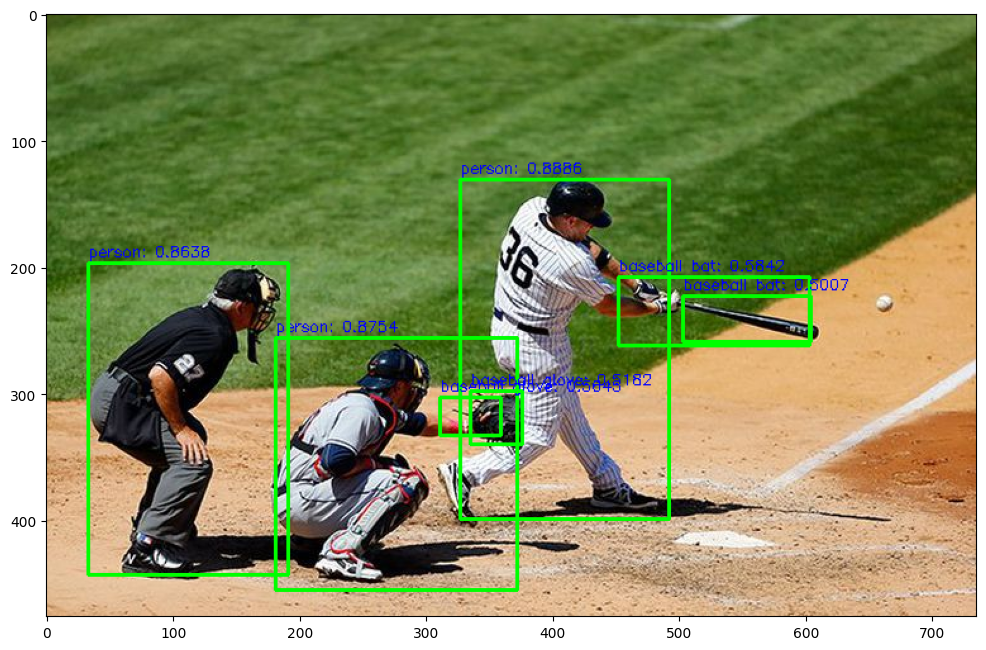

In [17]:
img_array = cv2.cvtColor(cv2.imread('/content/data/baseball01.jpg'), cv2.COLOR_BGR2RGB)
draw_img = get_detected_img(detector_model, img_array, score_threshold=0.5, object_show_count=100, is_print=True)

plt.figure(figsize=(12, 12))
plt.imshow(draw_img)

### Video Inference 수행

In [18]:
!wget -O ./data/Jonh_Wick_small.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true

--2023-06-15 14:32:42--  https://github.com/chulminkw/DLCV/blob/master/data/video/John_Wick_small.mp4?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4 [following]
--2023-06-15 14:32:42--  https://github.com/chulminkw/DLCV/raw/master/data/video/John_Wick_small.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4 [following]
--2023-06-15 14:32:42--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/John_Wick_small.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.

In [19]:
def do_detected_video(model, input_path, output_path, score_threshold, is_print):

    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)

    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break

        img_frame = get_detected_img(model, img_frame, score_threshold=score_threshold, object_show_count=100, is_print=is_print)

        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

In [20]:
do_detected_video(detector_model, '/content/data/Jonh_Wick_small.mp4', './data/John_Wick_small_02.mp4', 0.5, True)

총 Frame 갯수: 58
car: 0.6785
car: 0.5698
car: 0.5395
Detection 수행시간: 0.06 초
car: 0.6946
car: 0.5763
car: 0.5395
Detection 수행시간: 0.06 초
motorcycle: 0.6226
person: 0.5840
car: 0.5559
Detection 수행시간: 0.07 초
car: 0.5359
person: 0.5348
car: 0.5228
Detection 수행시간: 0.06 초
car: 0.6281
car: 0.6254
motorcycle: 0.6097
person: 0.5842
Detection 수행시간: 0.06 초
car: 0.6241
person: 0.6053
car: 0.5280
Detection 수행시간: 0.07 초
car: 0.6307
person: 0.5982
car: 0.5157
Detection 수행시간: 0.06 초
car: 0.6952
person: 0.6058
motorcycle: 0.5257
motorcycle: 0.5150
Detection 수행시간: 0.06 초
person: 0.6923
car: 0.6280
motorcycle: 0.5511
car: 0.5127
Detection 수행시간: 0.06 초
person: 0.6850
car: 0.6466
car: 0.5946
motorcycle: 0.5325
Detection 수행시간: 0.06 초
car: 0.6627
car: 0.6265
person: 0.5025
Detection 수행시간: 0.06 초
car: 0.6668
car: 0.6445
person: 0.5397
motorcycle: 0.5068
Detection 수행시간: 0.07 초
person: 0.5929
car: 0.5350
Detection 수행시간: 0.06 초
person: 0.6150
car: 0.5573
car: 0.5510
person: 0.5106
person: 0.5007
Detection 수행시간: 0.0